<a href="https://colab.research.google.com/github/GabrielYYM/Notebooks/blob/main/TreeForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SVM

PROCESSANDO DATASET: IRIS
Formas: X_train (120, 4) | X_test (30, 4)
------------------------------
[IRIS] Linear — Acurácia: 100.00%


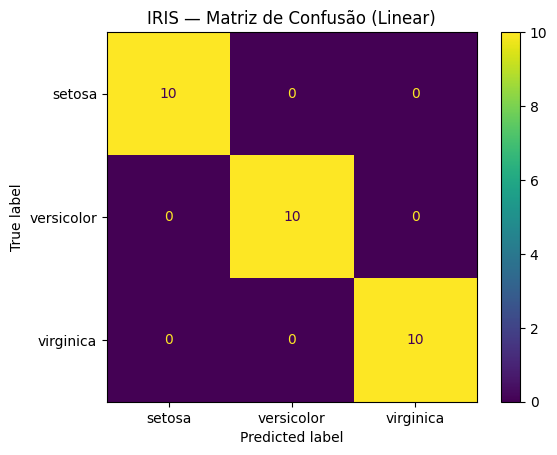


[IRIS] CV média (Linear) variando C:
  C=0.1: mean=0.9733
  C=1: mean=0.9733
  C=10: mean=0.9600
  C=100: mean=0.9667

############################################################
PROCESSANDO DATASET: BREAST CANCER WISCONSIN
Formas: X_train (455, 30) | X_test (114, 30)
------------------------------
[BREAST CANCER WISCONSIN] Linear — Acurácia: 95.61%


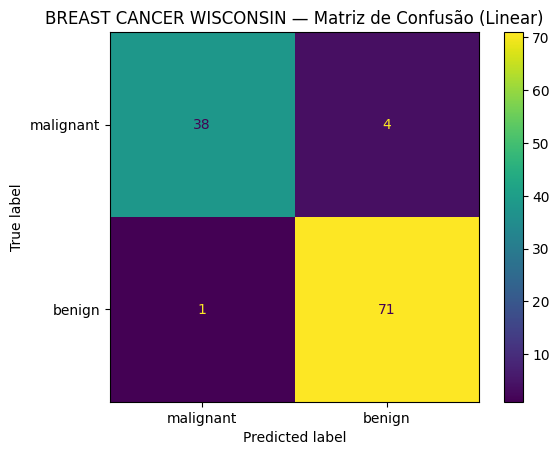


[BREAST CANCER WISCONSIN] CV média (Linear) variando C:
  C=0.1: mean=0.9543
  C=1: mean=0.9525
  C=10: mean=0.9595
  C=100: mean=0.9630

############################################################
PROCESSANDO DATASET: WINE
Formas: X_train (142, 13) | X_test (36, 13)
------------------------------
[WINE] Linear — Acurácia: 94.44%


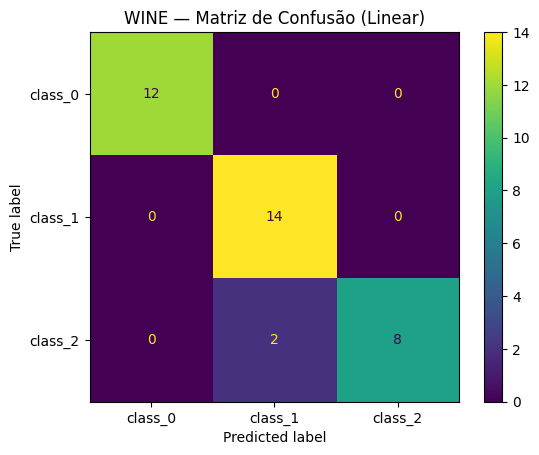


[WINE] CV média (Linear) variando C:
  C=0.1: mean=0.9608
  C=1: mean=0.9495
  C=10: mean=0.9495
  C=100: mean=0.9495

############################################################
PROCESSANDO DATASET: FISHMORPH FAMILY
  Skipping stratification for FISHMORPH FAMILY due to classes with less than 2 samples.
Formas: X_train (6673, 10) | X_test (1669, 10)
------------------------------
[FISHMORPH FAMILY] Linear — Acurácia: 53.80%
  Skipping Confusion Matrix plot for FISHMORPH FAMILY due to a large number of labels (197).

[FISHMORPH FAMILY] CV média (Linear) variando C:
  C=0.1: mean=0.4789
  C=1: mean=0.5586


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import pandas as pd

# Definir um estado aleatório fixo para reprodutibilidade
RANDOM_STATE = 42
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE) # Definição para o CV (Cross-Validation)

# Lista de datasets a serem processados (apenas SVC linear)
datasets_list = [
    ("IRIS", datasets.load_iris()),
    ("BREAST CANCER WISCONSIN", datasets.load_breast_cancer()),
    ("WINE", datasets.load_wine())
]

# Load additional datasets
fishmorph_family_df = pd.read_csv('/content/FISHMORPH_Family_Dataset.csv')
fishmorph_order_df = pd.read_csv('/content/FISHMORPH_Order_Dataset.csv')
mushroom_df = pd.read_csv('/content/mushroom_s7_all_features_ohe.csv')
pima_df = pd.read_csv('/content/diabetes.csv') # Corrected to read_csv

# Prepare data for the new datasets
fishmorph_family_data = (fishmorph_family_df.drop('Family', axis=1), fishmorph_family_df['Family'])
fishmorph_order_data = (fishmorph_order_df.drop('Order', axis=1), fishmorph_order_df['Order'])
mushroom_data = (mushroom_df.drop('class', axis=1), mushroom_df['class'])
pima_data = (pima_df.drop('Outcome', axis=1), pima_df['Outcome'])


# Add new datasets to the list
datasets_list.extend([
    ("FISHMORPH FAMILY", fishmorph_family_data),
    ("FISHMORPH ORDER", fishmorph_order_data),
    ("MUSHROOM", mushroom_data),
    ("PIMA DIABETES", pima_data)
])


def run_linear_svc_baseline(dataset_name, dataset):
    """Executa a linha de base (Baseline) — kernel linear para um dataset."""
    print("="*60)
    print(f"PROCESSANDO DATASET: {dataset_name}")
    print("="*60)

    # Check if dataset is a scikit-learn Bunch or a tuple (for custom dataframes)
    if isinstance(dataset, tuple):
        X, y = dataset
        # For custom dataframes, we need to handle non-numeric target labels if they exist
        if not np.issubdtype(y.dtype, np.number):
            from sklearn.preprocessing import LabelEncoder
            le = LabelEncoder()
            y_encoded = le.fit_transform(y)
            labels = le.classes_
        else:
            labels = np.unique(y)
            y_encoded = y
        X = X.values # Convert dataframe to numpy array
    else:
        X = dataset.data
        y = dataset.target
        labels = dataset.target_names if hasattr(dataset, 'target_names') else np.unique(y)
        y_encoded = y


    # Divisão treino/teste 80/20 estratificada
    # Need to handle cases where y is not numeric for stratification
    if np.issubdtype(y_encoded.dtype, np.number):
        # Check for classes with less than 2 samples for stratification
        class_counts = np.bincount(y_encoded)
        if np.min(class_counts) >= 2:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y_encoded, test_size=0.2, random_state=RANDOM_STATE, stratify=y_encoded
            )
        else:
             print(f"  Skipping stratification for {dataset_name} due to classes with less than 2 samples.")
             X_train, X_test, y_train, y_test = train_test_split(
                X, y_encoded, test_size=0.2, random_state=RANDOM_STATE
             )

    else: # Fallback for non-numeric labels if stratification is not possible
         X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=0.2, random_state=RANDOM_STATE
        )


    print("Formas:", "X_train", X_train.shape, "| X_test", X_test.shape)
    # print("Distribuição de classes (treino):", np.bincount(y_train)) # This will fail for non-numeric y_train
    # print("Distribuição de classes (teste) :", np.bincount(y_test)) # This will fail for non-numeric y_test


    # 1) Baseline — kernel linear
    model = SVC(kernel='linear', random_state=RANDOM_STATE)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print("-" * 30)
    print(f"[{dataset_name}] Linear — Acurácia: {acc*100:.2f}%")
    # print("Preditos (10):", y_pred[:10]) # This will fail for non-numeric y_pred
    # print("Reais    (10):", y_test[:10]) # This will fail for non-numeric y_test

    # Visualização da Matriz de Confusão
    if len(labels) <= 50:  # Skip plotting for datasets with too many labels
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=labels)
        plt.title(f"{dataset_name} — Matriz de Confusão (Linear)")
        plt.show()
    else:
        print(f"  Skipping Confusion Matrix plot for {dataset_name} due to a large number of labels ({len(labels)}).")


    # 4a) Linear: variação de C (Adicionado conforme sua solicitação original)
    Cs = [0.1, 1, 10, 100]
    print(f"\n[{dataset_name}] CV média (Linear) variando C:")
    for C in Cs:
        # Need to handle cases where y is not numeric for cross_val_score
        if np.issubdtype(y_encoded.dtype, np.number):
            scores = cross_val_score(SVC(kernel='linear', C=C, random_state=RANDOM_STATE), X, y_encoded, cv=cv, n_jobs=-1)
        else: # Fallback for non-numeric labels if cross-validation is not possible
            print(f"  Cross-validation skipped for C={C} due to non-numeric target labels.")
            scores = [] # Empty list to avoid errors

        if len(scores) > 0:
            print(f"  C={C}: mean={scores.mean():.4f}")


    print("\n" + "#"*60)


# Executar a função para cada dataset
for name, data in datasets_list:
    run_linear_svc_baseline(name, data)